In [1]:
# This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '/home/lh/PycharmProjects/cs231n/assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd $FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd $FOLDERNAME

/home/lh/PycharmProjects/cs231n/assignment1/cs231n/datasets
/home/lh/PycharmProjects/cs231n/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.327125
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ because the Law of large numbers. Because the W are randomly chosen , the output is close to a uniform distribution on 10 possible classes. The exception of $\frac{e^{f_{yi}}}{\sum_{j}e^{f_j}}$ with a large n is 0.1 .


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.652608 analytic: 1.652608, relative error: 2.795436e-09
numerical: -1.299235 analytic: -1.299235, relative error: 2.957909e-08
numerical: -6.131454 analytic: -6.131454, relative error: 1.633961e-09
numerical: 0.959836 analytic: 0.959836, relative error: 4.885796e-08
numerical: -0.727496 analytic: -0.727496, relative error: 5.501108e-08
numerical: 1.258069 analytic: 1.258069, relative error: 6.841941e-09
numerical: -1.322481 analytic: -1.322481, relative error: 6.458241e-09
numerical: -2.084480 analytic: -2.084480, relative error: 6.593573e-09
numerical: -1.278945 analytic: -1.278945, relative error: 4.057350e-08
numerical: 1.362659 analytic: 1.362659, relative error: 5.136287e-09
numerical: -1.003727 analytic: -1.003727, relative error: 1.190797e-08
numerical: -2.071057 analytic: -2.071057, relative error: 2.271474e-09
numerical: 0.631511 analytic: 0.631511, relative error: 2.352973e-08
numerical: -0.090257 analytic: -0.090257, relative error: 1.928438e-07
numerical: -0.89

In [12]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.327125e+00 computed in 0.021811s
vectorized loss: 2.327125e+00 computed in 0.001813s
Loss difference: 0.000000
Gradient difference: 0.000000


  0%|          | 0/5 [00:00<?, ?it/s]

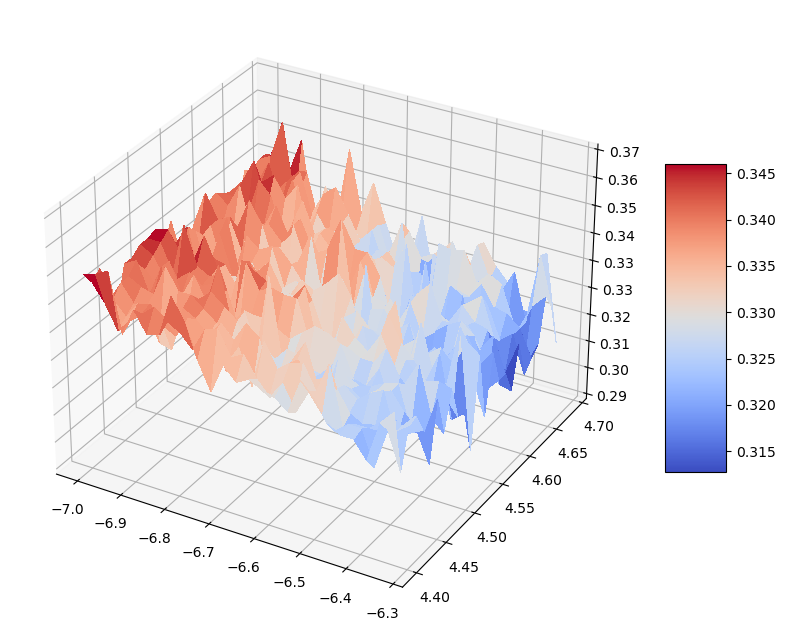

 20%|██        | 1/5 [11:11<44:45, 671.33s/it]

best{(4.3959465577043494e-07, 26425.45101403445): [0.333265306122449, 0.356]}
adjust gird from (1e-07,24999.999999999993) -> (4.6882547700099664e-07,48632.74737061312)
decrease area
[1.13741146e-07 1.90365394e-07 2.62652780e-07 2.16523781e-07
 1.78496293e-07 1.29370483e-07 1.47147471e-07 3.18609267e-07
 1.47147471e-07 2.46276630e-07 1.00000000e-07 4.68825477e-07
 1.00000000e-07 1.00000000e-07 3.39795172e-07 4.68825477e-07
 2.46276630e-07 1.00000000e-07 1.67367220e-07 4.39594656e-07]
[25000.         26425.45101403 27932.17845181 27932.17845181
 27932.17845181 27932.17845181 30354.87210988 27168.37156315
 33915.10818619 25702.8456664  25000.         27168.37156315
 30354.87210988 25702.8456664  26425.45101403 30354.87210988
 34868.59165876 26425.45101403 27168.37156315 26425.45101403]
expand gird to (1e-07,24999.999999999993) -> (4.4072811501808653e-07,34407.61980019587)


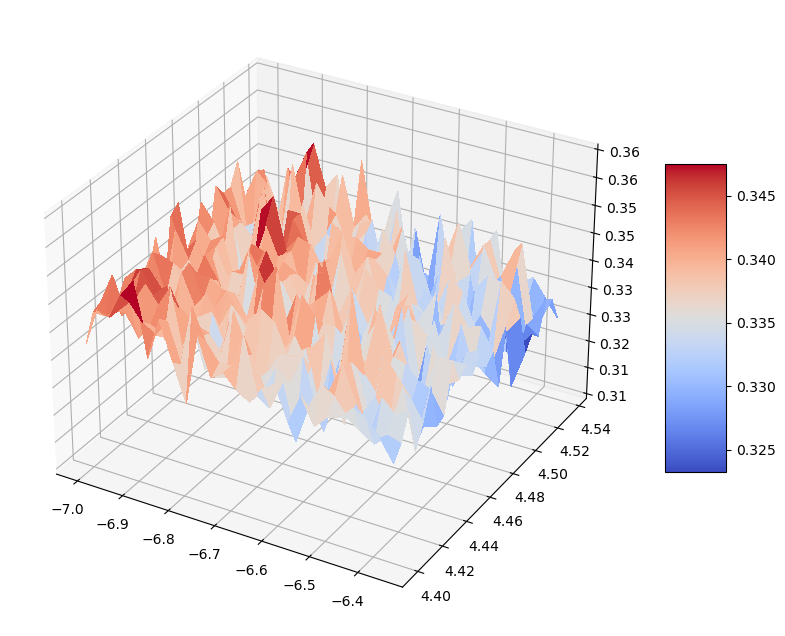

 40%|████      | 2/5 [22:15<33:21, 667.19s/it]

best{(1.3620788232093395e-07, 31766.98333355199): [0.32910204081632655, 0.355]}
adjust gird from (1e-07,24999.999999999993) -> (4.4072811501808653e-07,34407.61980019587)
decrease area
[1.06375214e-07 1.00000000e-07 1.13156862e-07 1.97353544e-07
 2.52700861e-07 2.37556148e-07 1.54128566e-07 3.44198492e-07
 3.66141884e-07 2.85948366e-07 1.85525872e-07 4.40728115e-07
 2.09935255e-07 4.14314667e-07 1.74407049e-07 4.40728115e-07
 1.54128566e-07 1.00000000e-07 2.52700861e-07 1.36207882e-07]
[27808.54178073 26018.32513048 25334.93442822 25000.
 26720.14978028 26018.32513048 32192.57758951 25000.
 26366.90244451 26366.90244451 29721.93606209 27808.54178073
 25000.         26366.90244451 28181.10330237 26366.90244451
 28941.26725823 26366.90244451 27078.12970382 31766.98333355]
expand gird to (1e-07,24999.999999999993) -> (4.153401598928715e-07,31868.609996312534)


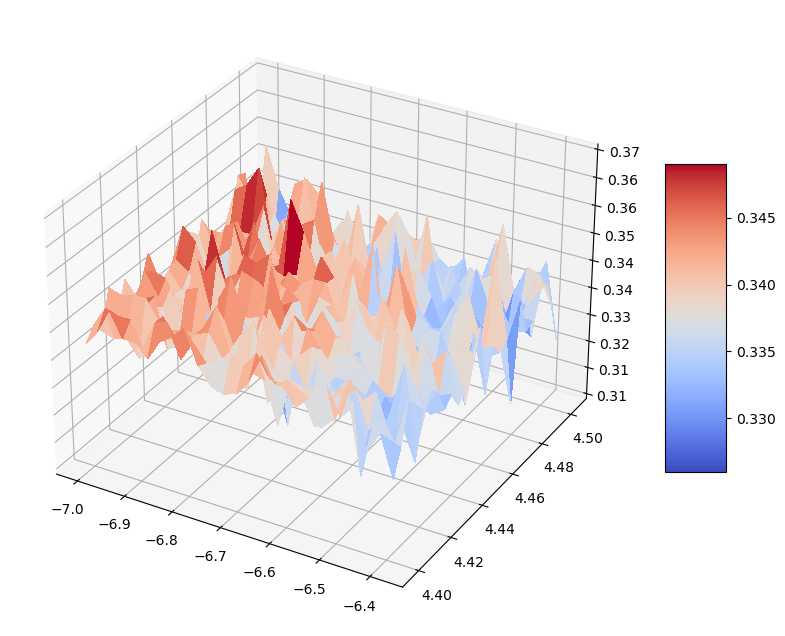

 60%|██████    | 3/5 [33:25<22:17, 668.63s/it]

best{(2.2947512936393517e-07, 27106.974438754354): [0.32893877551020406, 0.359]}
adjust gird from (1e-07,24999.999999999993) -> (4.153401598928715e-07,31868.609996312534)
decrease area
[1.70569538e-07 2.58386181e-07 3.47618943e-07 1.92059208e-07
 3.27594502e-07 2.16256312e-07 2.29475129e-07 2.16256312e-07
 2.29475129e-07 4.15340160e-07 2.90939672e-07 1.42758173e-07
 3.47618943e-07 2.43501956e-07 1.60743952e-07 1.80995719e-07
 3.27594502e-07 2.58386181e-07 2.90939672e-07 2.29475129e-07]
[26296.81536745 29391.52252893 29095.74314352 25254.14317822
 27660.89993879 26032.17933575 26296.81536745 29690.30872686
 27382.53654419 25000.         25510.86990665 27106.97443875
 26296.81536745 28802.9403118  27660.89993879 26032.17933575
 26834.18543193 31547.90262672 25770.20644894 27106.97443875]
expand gird to (1.4275817305343233e-07,24999.999999999993) -> (3.979713497165536e-07,31255.70306629154)


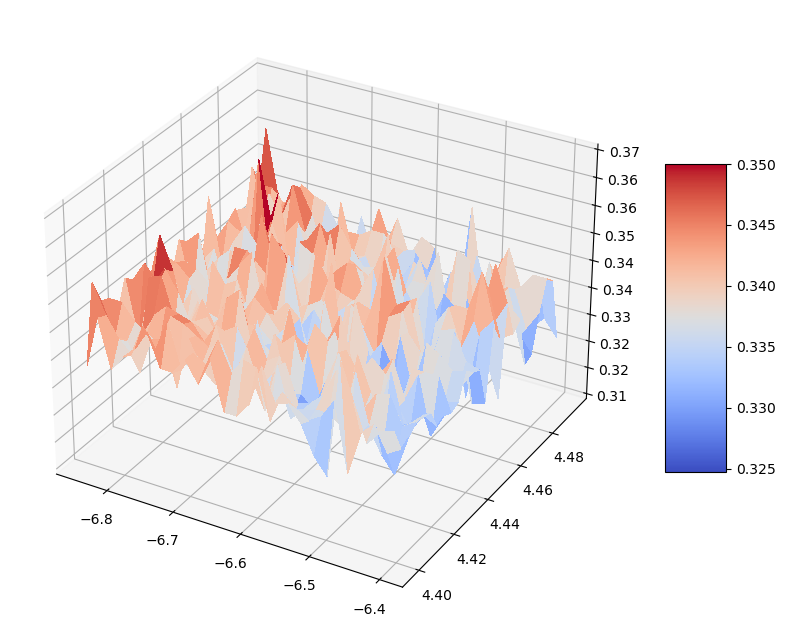

 80%|████████  | 4/5 [44:36<11:09, 669.49s/it]

best{(3.079917626876725e-07, 25707.726248720734): [0.3327551020408163, 0.361]}
adjust gird from (1.4275817305343233e-07,24999.999999999993) -> (3.979713497165536e-07,31255.70306629154)
decrease area
[3.07991763e-07 1.84464878e-07 2.38356168e-07 3.50102696e-07
 2.82770999e-07 1.76750874e-07 3.65382357e-07 3.21433561e-07
 2.82770999e-07 2.82770999e-07 3.97971350e-07 1.48988621e-07
 2.70946003e-07 2.48758834e-07 1.42758173e-07 2.28388524e-07
 2.00917573e-07 2.48758834e-07 3.97971350e-07 3.07991763e-07]
[30679.39801589 25233.71699543 27183.85109279 25948.05955025
 27437.98421285 25707.72624872 25000.         25948.05955025
 30679.39801589 25000.         29284.69715217 25000.
 26190.63965086 26682.62446413 30113.71910659 28214.72747843
 25233.71699543 29013.45960791 25000.         25707.72624872]
expand gird to (1.4275817305343233e-07,24999.999999999993) -> (3.819810119457197e-07,30429.201825784457)


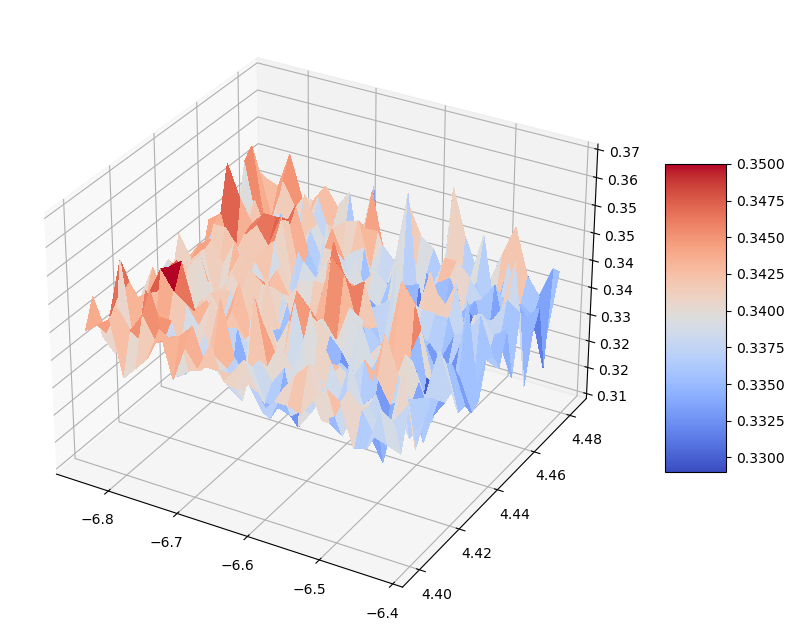

100%|██████████| 5/5 [55:51<00:00, 670.24s/it]

best{(2.866629352675748e-07, 25205.55599152486): [0.3351224489795918, 0.357]}
adjust gird from (1.4275817305343233e-07,24999.999999999993) -> (3.819810119457197e-07,30429.201825784457)
decrease area
[3.66633160e-07 2.24135860e-07 3.51901979e-07 3.51901979e-07
 3.81981012e-07 1.54960514e-07 1.75247224e-07 3.37762691e-07
 1.82583354e-07 1.61447409e-07 2.43294007e-07 2.24135860e-07
 1.68205857e-07 2.43294007e-07 1.61447409e-07 2.15130166e-07
 3.51901979e-07 3.66633160e-07 3.24191514e-07 2.86662935e-07]
[29690.78921038 28036.76043241 27808.11544272 27133.30762584
 25412.80211368 25832.42045075 25621.75226311 25000.
 25832.42045075 26912.03046162 27581.3350954  27808.11544272
 27356.40418393 28734.03720238 25205.55599152 29208.49605404
 25000.         28499.7057911  28036.76043241 25205.55599152]
expand gird to (1.5496051375225212e-07,24999.999999999993) -> (3.684418428180547e-07,29487.26361643664)
lr 1.362079e-07 reg 3.176698e+04 train accuracy: 0.329102 val accuracy: 0.355000
lr 2.294751e

In [14]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
from tqdm import tqdm
from cs231n.classifiers.linear_svm import visualize_lr_reg_valloss,division_10exponential_to_k,generation_space
# set split k_fold of each range
k_fold = 25
# set iteration times
max_iter = 5
# set top_k value as the last searching space
top_k = 20
lr_range = division_10exponential_to_k(learning_rates[0],learning_rates[1],k_fold)
reg_range = division_10exponential_to_k(regularization_strengths[0],regularization_strengths[1],k_fold)
search_space = [(x,y) for x in lr_range for y in reg_range]
for i in tqdm(range(max_iter)):
    results_acc = []
    for para in search_space:
        # search in space
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=para[0], reg=para[1],
                      num_iters=1500, verbose=False)
        results_acc.append([np.mean(y_train==softmax.predict(X_train)),np.mean(y_val==softmax.predict(X_val))])
    visualize_lr_reg_valloss(lr_range,reg_range,results_acc,i)
    lr_range,reg_range,search_space,dict_result = generation_space(lr_range, reg_range, results_acc,k_fold,top_k)
    results.update(dict_result)

    #todo: visualize the results
    #   -with exponents
    #   - 3-D pic
    #todo: select top-k ,and continue loop
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

In [16]:
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

    best_val = val_accuracy if val_accuracy > best_val else best_val

print('best validation accuracy achieved during cross-validation: %f' % best_val)
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    if val_accuracy == best_val:
        best_softmax = Softmax()
        best_softmax.train(X_train, y_train, learning_rate=para[0], reg=para[1],
                      num_iters=1500, verbose=False)
        break


lr 1.362079e-07 reg 3.176698e+04 train accuracy: 0.329102 val accuracy: 0.355000
lr 2.294751e-07 reg 2.710697e+04 train accuracy: 0.328939 val accuracy: 0.359000
lr 2.866629e-07 reg 2.520556e+04 train accuracy: 0.335122 val accuracy: 0.357000
lr 3.079918e-07 reg 2.570773e+04 train accuracy: 0.332755 val accuracy: 0.361000
lr 4.395947e-07 reg 2.642545e+04 train accuracy: 0.333265 val accuracy: 0.356000
best validation accuracy achieved during cross-validation: 0.361000


In [18]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.329000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$

To add an point that not change the result of max

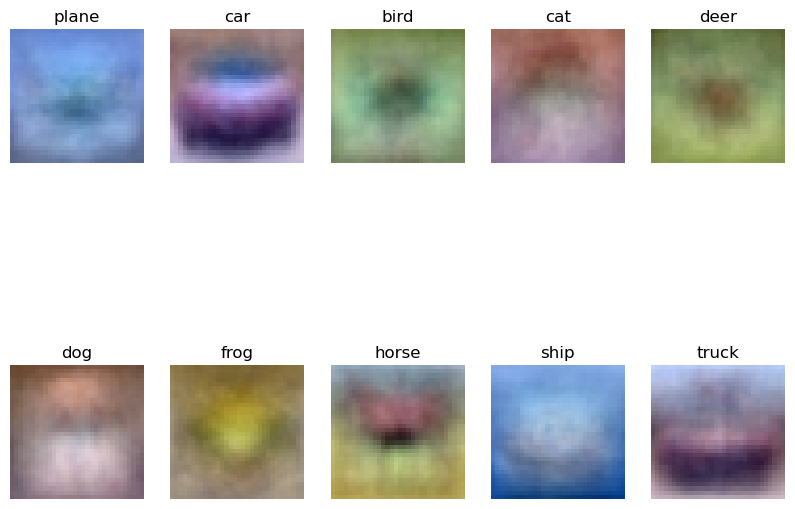

In [19]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])